In [16]:
from keras.optimizers import Adam, RMSprop
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import regularizers
import pandas as pd
import time,os
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
data_path = 'data'
train_path = os.path.join(data_path,'train.txt')
test_path = os.path.join(data_path,'test.txt')

In [10]:
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","error_rate", "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data.columns = columns
test_data.columns = columns

# Data Preprocessing

In [11]:
# One-Hot encoding of labels
train_Y = train_data.pop('attack').values
test_Y = test_data.pop('attack').values

train_Y = np.array(['attack' if t != 'normal' else t  for t in train_Y])
test_Y = np.array(['attack' if t != 'normal' else t  for t in test_Y])
ohe = OneHotEncoder()
train_Y = ohe.fit_transform(train_Y.reshape(-1,1)).toarray()
test_Y = ohe.fit_transform(test_Y.reshape(-1,1)).toarray()

#train_X, train_Y = train_data.loc[:,train_data.columns != 'attack'].values, train_data['attack'].values
#test_X, test_Y = test_data.loc[:,test_data.columns != 'attack'].values, test_data['attack'].values

In [12]:
# One-Hot encoding of categorical/nominal features
categorical_columns = ['protocol_type', 'service', 'flag']
train_X_categorical = train_data.loc[:,categorical_columns].values
test_X_categorical = test_data.loc[:,categorical_columns].values

#train_X_categorical = ohe.fit_transform(train_X_categorical).toarray()
#test_X_categorical = ohe.fit_transform(test_X_categorical).toarray()

# Manual One-Hot Encoding
train_X_services_size = len(set(train_X_categorical[:,1]))
test_X_services_size = len(set(test_X_categorical[:,1]))
                           
if train_X_services_size > test_X_services_size:
    services = list(set(train_X_categorical[:,1]))
else:
    services = list(set(test_X_categorical[:,1]))
                    
vector_size = max(train_X_services_size, test_X_services_size)
train_one_hot_vector = np.zeros((train_X_categorical.shape[0],vector_size))
test_one_hot_vector = np.zeros((test_X_categorical.shape[0],vector_size))

for i,v in enumerate(train_X_categorical[:,1]):
    service_index = services.index(v)
    train_one_hot_vector[i][service_index] = 1
                    
for i,v in enumerate(test_X_categorical[:,1]):
    service_index = services.index(v)
    test_one_hot_vector[i][service_index] = 1

train_X_categorical = train_one_hot_vector
test_X_categorical = test_one_hot_vector

In [13]:
# Normalization of numerical data
numerical_columns = ['duration','src_bytes','dst_bytes', 'wrong_fragment', 'urgent', 'hot','num_failed_logins','num_compromised', 'num_root', 'num_file_creations','num_shells','num_access_files','num_outbound_cmds','count', 'srv_count', 'dst_host_count', 'dst_host_srv_count','last_flag']

sc = StandardScaler()
train_X_numerical = train_data.loc[:,numerical_columns].values
test_X_numerical = test_data.loc[:,numerical_columns].values

train_X_numerical = sc.fit_transform(train_X_numerical)
test_X_numerical = sc.fit_transform(test_X_numerical)
rate_columns = ['error_rate','srv_serror_rate', 'rerror_rate','srv_rerror_rate', 'same_srv_rate','diff_srv_rate','srv_diff_host_rate', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate']
train_X_rate = train_data.loc[:,rate_columns].values
test_X_rate = test_data.loc[:,rate_columns].values


In [14]:
train_X = np.hstack((train_X_categorical,train_X_numerical,train_X_rate))
test_X = np.hstack((test_X_categorical,test_X_numerical,test_X_rate))

In [91]:
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [161]:
units = 2**4
epochs = 5
batch_size = 2**8
lr = 1e-2 # default for Adam 1e-3
dropout = 0.5

def run_model(units, epochs, batch_size,lr, dropout):
    # ML Model
    model = Sequential()
    model.add(layers.Dropout(dropout/2))
    model.add(layers.Dense(units, input_shape=(train_X.shape[1],),kernel_initializer='random_normal',kernel_regularizer=regularizers.l2(1e-4),activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2, activation='softmax'))

    #print(model.summary())

    # Compile model
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_Y))
    return model, history

m, h = run_model(units, epochs, batch_size,lr, dropout)

Epoch 1/5
493/493 [==============================] - 1s 3ms/step - loss: 0.1204 - acc: 0.9611 - val_loss: 0.6342 - val_acc: 0.8164
Epoch 2/5
493/493 [==============================] - 1s 2ms/step - loss: 0.1044 - acc: 0.9653 - val_loss: 0.6153 - val_acc: 0.8182
Epoch 3/5
493/493 [==============================] - 1s 2ms/step - loss: 0.1005 - acc: 0.9664 - val_loss: 0.6825 - val_acc: 0.8236
Epoch 4/5
493/493 [==============================] - 1s 3ms/step - loss: 0.1010 - acc: 0.9659 - val_loss: 0.7151 - val_acc: 0.8058
Epoch 5/5
493/493 [==============================] - 2s 3ms/step - loss: 0.1020 - acc: 0.9662 - val_loss: 0.6956 - val_acc: 0.8193


In [162]:
val_acc = [0]
#while (val_acc[-1] < 0.90):
val_acc = h.history.get('val_acc')
#print(val_acc)
    
    
loss = h.history.get('loss')
acc = h.history.get('acc')
val_loss = h.history.get('val_loss')
ep = range(1,len(acc)+1)

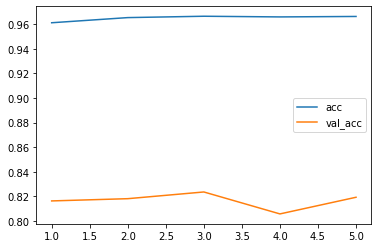

In [163]:
plt.plot(ep, acc,label='acc')
plt.plot(ep, val_acc, label='val_acc')
plt.legend(loc='best')

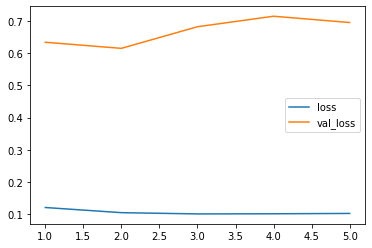

In [164]:
plt.plot(ep, loss,label='loss')
plt.plot(ep, val_loss,label='val_loss')
plt.legend(loc='best')

In [28]:
#train_Y = [1. if r == 'attack' else 0. for r in train_Y]
#test_Y = [1. if r == 'attack' else 0. for r in test_Y]
#train_Y

In [ ]:
#from sklearn import svm, metrics
#from sklearn.linear_model import LogisticRegression

In [ ]:
#classifier = svm.SVC(kernel='sigmoid',C = 1e-2)

In [ ]:
#classifier = LogisticRegression(penalty='l2',C = 1e-2,random_state = 0)

In [ ]:
#classifier.fit(train_X, train_Y)

In [ ]:
#pred_Y = classifier.predict(test_X)
#print("Accuracy:",metrics.accuracy_score(test_Y, pred_Y))
#print("Precision:",metrics.precision_score(test_Y, pred_Y))

# Model Recall: what percentage of positive tuples are labelled as such?
#print("Recall:",metrics.recall_score(test_Y, pred_Y))

In [166]:
m.save('model_82.h5')